In [47]:
#Python version
!python --version

Python 3.8.5


https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html

In [48]:
#Install uninstalled modules, comment if it's already installed

#!pip install ipykernel
#!pip install MetaTrader5==5.0.34
#!pip install gym
#!pip install gym-anytrading
#!pip install tensorflow

In [49]:
#Import needed modules
import gym
import gym_anytrading
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd

import random, datetime, os, copy
import MetaTrader5 as mt5

In [50]:
# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    mt5.shutdown()
 
# display data on MetaTrader 5 version
print(mt5.version())

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

"""
# Initialize Metatrader on a certain day
if datetime.datetime.now() == weekdays:
    # now connect to another trading account specifying the password
    account = #Account number
    password = #Password number
    server = #Server name
    authorized=mt5.login(account, password, server)
    if authorized:
        # display trading account data 'as is'
        print(mt5.account_info())
        # display trading account data in the form of a list
        print("Show account_info()._asdict():")
        account_info_dict = mt5.account_info()._asdict()
        for prop in account_info_dict:
            print("  {}={}".format(prop, account_info_dict[prop]))
    else:
        print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))
# shut down connection to the MetaTrader 5 terminal
else:
    mt5.shutdown()
"""

MetaTrader5 package author:  MetaQuotes Software Corp.
MetaTrader5 package version:  5.0.34
initialize() failed, error code = (-10003, 'IPC initialize failed, MetaTrader 5 x64 not found')
(0, 0, '')


'\n# Initialize Metatrader on a certain day\nif datetime.datetime.now() == weekdays:\n    # now connect to another trading account specifying the password\n    account = #Account number\n    password = #Password number\n    server = #Server name\n    authorized=mt5.login(account, password, server)\n    if authorized:\n        # display trading account data \'as is\'\n        print(mt5.account_info())\n        # display trading account data in the form of a list\n        print("Show account_info()._asdict():")\n        account_info_dict = mt5.account_info()._asdict()\n        for prop in account_info_dict:\n            print("  {}={}".format(prop, account_info_dict[prop]))\n    else:\n        print("failed to connect at account #{}, error code: {}".format(account, mt5.last_error()))\n# shut down connection to the MetaTrader 5 terminal\nelse:\n    mt5.shutdown()\n'


env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (800,)
> signal_features.shape: (800, 2)
> max_possible_profit: 1.2961057376950926


> possible action: Discrete(2)
> observation space: Box(-inf, inf, (10, 2), float32)


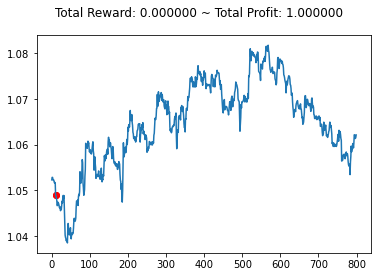

In [51]:
env = gym.make('forex-v0',
               df = FOREX_EURUSD_1H_ASK,
               window_size = 10,
               frame_bound = (10, 800), #Max 6225 Rows of data
               unit_side = 'right')

seed = 42
env.seed(seed)
eps = np.finfo(np.float32).eps.item()

print()
print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("\n")
print("> possible action:", env.action_space)
print("> observation space:", env.observation_space)

env.reset() # Uncomment if you need it.
env.render()


In [52]:
print(env.df)
print("\n")
env.df.info()

                        Open     High      Low    Close        Volume
Time                                                                 
2017-01-01 22:00:00  1.05236  1.05253  1.05221  1.05227  1.435400e+08
2017-01-01 23:00:00  1.05227  1.05426  1.05226  1.05282  2.531400e+08
2017-02-01 00:00:00  1.05283  1.05283  1.05268  1.05281  1.314000e+08
2017-02-01 01:00:00  1.05282  1.05286  1.05225  1.05240  2.739400e+08
2017-02-01 02:00:00  1.05239  1.05240  1.05164  1.05220  2.581400e+08
...                      ...      ...      ...      ...           ...
2017-12-29 17:00:00  1.20224  1.20257  1.20191  1.20218  9.283300e+09
2017-12-29 18:00:00  1.20218  1.20242  1.20122  1.20139  7.366750e+09
2017-12-29 19:00:00  1.20139  1.20144  1.20073  1.20096  7.205770e+09
2017-12-29 20:00:00  1.20098  1.20109  1.19978  1.19982  6.679810e+09
2017-12-29 21:00:00  1.19984  1.20130  1.19931  1.20075  4.885530e+09

[6225 rows x 5 columns]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6225 entri

info: {'total_reward': -415.9999999999564, 'total_profit': 0.9327548084067188, 'position': 1}


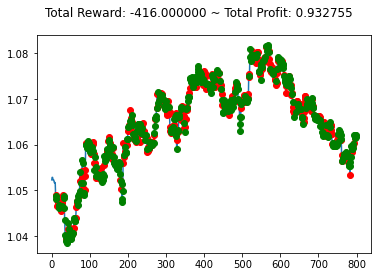

In [53]:
# Based on random actions

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    # env.render()
    if done:
        print("info:", info)
        break

plt.cla()
env.render_all()
plt.show()

In [61]:
num_inputs = 5
num_actions = 1
num_hidden = 128

inputs = layers.Input(shape=(num_inputs))
common = layers.Dense(num_hidden, activation="relu")(inputs)
action = layers.Dense(num_actions, activation="sigmoid")(common)
critic = layers.Dense(1)(common)

model = keras.Model(inputs=inputs, outputs=[action, critic])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 128)          768         input_12[0][0]                   
__________________________________________________________________________________________________
dense_34 (Dense)                (None, 1)            129         dense_33[0][0]                   
__________________________________________________________________________________________________
dense_35 (Dense)                (None, 1)            129         dense_33[0][0]                   
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_______________________

In [62]:
gamma = 0.99  # Discount factor for past rewards
max_steps_per_episode = 10000
optimizer = keras.optimizers.Adam(learning_rate=0.01)
huber_loss = keras.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0

while True:  # Run until solved
    state = env.reset()
    episode_reward = 0
    with tf.GradientTape() as tape:
        for timestep in range(1, max_steps_per_episode):
            # env.render(); Adding this line would show the attempts
            # of the agent in a pop up window.

            state = tf.convert_to_tensor(state)
            state = tf.expand_dims(state, 0)

            # Predict action probabilities and estimated future rewards
            # from environment state
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Sample action from action probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            # Apply the sampled action in our environment
            state, reward, done, _ = env.step(action)
            rewards_history.append(reward)
            episode_reward += reward

            if done:
                break

        # Update running reward to check condition for solving
        running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

        # Calculate expected value from rewards
        # - At each timestep what was the total reward received after that timestep
        # - Rewards in the past are discounted by multiplying them with gamma
        # - These are the labels for our critic
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma * discounted_sum
            returns.insert(0, discounted_sum)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()

        # Calculating loss values to update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            # At this point in history, the critic estimated that we would get a
            # total reward = `value` in the future. We took an action with log probability
            # of `log_prob` and ended up recieving a total reward = `ret`.
            # The actor must be updated so that it predicts an action that leads to
            # high rewards (compared to critic's estimate) with high probability.
            diff = ret - value
            actor_losses.append(-log_prob * diff)  # actor loss

            # The critic must be updated so that it predicts a better estimate of
            # the future rewards.
            critic_losses.append(
                huber_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            )

        # Backpropagation
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Clear the loss and reward history
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

    # Log details
    episode_count += 1
    if episode_count % 10 == 0:
        template = "running reward: {:.2f} at episode {}"
        print(template.format(running_reward, episode_count))

    if running_reward > 195:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break
    
    env.render()

ValueError: Input 0 is incompatible with layer model_11: expected shape=(None, 5), found shape=(1, 10, 2)